In [67]:
from simulation import  *

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import matplotlib.cm

In [68]:
length = 16
timesteps = 32 # Resolution for timesteps and weights
window_size = 3
num_neurons = 64 # Number of excitatory neurons in the column
threshold = 32 # Firing threshold for every excitatory neuron
rf_size = window_size*2
inchannels = 1


simulation = Simulation()
corpus = Corpus()
sentences = simulation.construct_sentences()
tokens = corpus.tokenize(sentences)



#corpus.dictionary.get_encoding(length,timesteps)
corpus.dictionary.get_gaussian_encoding(40, length , timesteps, 16)
spike_data = SpikeData(tokens, sentences, corpus)
spike_input, spike_output = spike_data.convert_tokens(window_size)

temporal_transform = utils.Intensity2Latency(timesteps)

def getContext(word):
    idx = corpus.dictionary.word2idx[word]
    enc = corpus.dictionary.idx2spike[idx]
    context = spike_input[np.all(spike_output == enc, axis=1)]
    print(context.shape)
    context = torch.from_numpy(context)
    context = temporal_transform(context)
    return context.sign()

def getContext2(word):
    idx = corpus.dictionary.word2idx[word]
    enc = corpus.dictionary.idx2spike[idx]
    context = spike_input[np.all(spike_output == enc, axis=1)]
    rev = np.array([(3-s) for s in context])
    comb = np.stack([context, rev])
    context = torch.from_numpy(comb)
    context = temporal_transform(context) #[4, 2, 480, 4, 3]
    return context.sign()

cat_context = getContext('cat')
dog_context = getContext('dog')
sit_context = getContext('sits')
eat_context = getContext('eats')


class DatasetContext(Dataset):
    def __init__(self, context, transform=None):
        self.data = context
        
    def __len__(self):
        return self.data.size(1)
    
    def __getitem__(self, index):
        image = self.data[:,index,:,:].reshape((self.data.size(0),1, self.data.size(2), -1))        
        return image

class DatasetContext2(Dataset):
    def __init__(self, context, transform=None):
        self.data = context
        
    def __len__(self):
        return self.data.size(2)
    
    def __getitem__(self, index):
        image = self.data[:,:,index,:,:].reshape((self.data.size(0),2, self.data.size(3), -1))        
        return image


idx2spike:(40, 16)
idx2spike:[[ 1.  0.  0.  1.  2.  4.  6.  8. 11. 14. 17. 19. 22. 24. 26. 27.]
 [ 1.  0.  0.  0.  1.  3.  5.  7. 10. 13. 16. 18. 21. 23. 25. 26.]
 [ 2.  1.  0.  0.  1.  2.  4.  6.  9. 12. 14. 17. 20. 22. 24. 26.]
 [ 2.  1.  0.  0.  0.  2.  3.  5.  8. 10. 13. 16. 18. 21. 23. 25.]
 [ 3.  2.  1.  0.  0.  1.  2.  4.  7.  9. 12. 15. 17. 20. 22. 24.]
 [ 4.  2.  1.  0.  0.  1.  2.  3.  6.  8. 11. 13. 16. 19. 21. 23.]
 [ 5.  3.  1.  0.  0.  0.  1.  3.  5.  7.  9. 12. 15. 18. 20. 22.]
 [ 6.  4.  2.  1.  0.  0.  1.  2.  4.  6.  8. 11. 14. 17. 19. 21.]
 [ 7.  5.  3.  1.  0.  0.  0.  1.  3.  5.  7. 10. 13. 15. 18. 20.]
 [ 8.  6.  4.  2.  1.  0.  0.  1.  2.  4.  6.  9. 11. 14. 17. 19.]
 [ 9.  7.  5.  3.  1.  0.  0.  0.  1.  3.  5.  8. 10. 13. 16. 18.]
 [11.  8.  6.  3.  2.  1.  0.  0.  1.  2.  4.  6.  9. 12. 14. 17.]
 [12.  9.  7.  4.  2.  1.  0.  0.  1.  2.  3.  5.  8. 11. 13. 16.]
 [13. 10.  8.  5.  3.  2.  0.  0.  0.  1.  2.  4.  7.  9. 12. 15.]
 [14. 12.  9.  6.  4.  2.  1.  0.

In [69]:
cat_context2 = getContext2('cat')
dog_context2 = getContext2('dog')
sit_context2 = getContext2('sits')
eat_context2 = getContext2('eats')
cat_context1 = getContext('cat')
dog_context1 = getContext('dog')
sit_context1 = getContext('sits')
eat_context1 = getContext('eats')


(480, 6, 16)
(480, 6, 16)
(480, 6, 16)
(480, 6, 16)


In [70]:
expect = torch.zeros(40)
print(expect)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [71]:

class Column(nn.Module):
    def __init__(self, num_neurons, threshold, kwta, inhibition_radius):
        super(Column, self).__init__()
        self.k = num_neurons
        self.thresh = threshold
        self.kwta = kwta
        self.inhibition_radius = inhibition_radius
        self.ec = snn.LocalConvolution(input_size=(rf_size,length),
                                       in_channels=inchannels,
                                       out_channels=self.k,
                                       kernel_size=(rf_size,length),
                                       stride=1)
        self.stdp = snn.ModSTDP(self.ec, 10/128, 10/128, 1/128, 96/128, 4/128, maxweight = timesteps)

    def forward(self, rec_field):
        out = self.ec(rec_field)
        spike, pot = sf.fire(out, self.thresh, True)
        winners = sf.get_k_winners(pot, kwta = self.kwta, inhibition_radius = self.inhibition_radius)
        coef = torch.zeros_like(out)
        coef[:,winners,:,:] = 1
        return torch.mul(pot, coef).sign()
    
 

In [72]:

### Column Initialization ###

MyColumn = Column(num_neurons, threshold, num_neurons, 0)
    
cat = DatasetContext(cat_context1)
trainLoader = DataLoader(cat, batch_size=1000, shuffle=True)
print(spike_input.shape)

# expect = torch.zeros(( 30,2))
# expect[10,:] = 3
# expect[20] = 2
# expect = temporal_transform(expect)
# print(expect.size())


num_epochs = 40
result = torch.zeros(num_epochs*cat.__len__(), num_neurons)
for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

(24000, 6, 16)




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
Training done under1.4260289669036865




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:02<00:00,  2.20s/it]
Training done under2.2030999660491943




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:03<00:00,  3.50s/it]
Training done under3.503556251525879




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:04<00:00,  4.92s/it]
Training done under4.9278669357299805




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:05<00:00,  5.03s/it]
Training done under5.039574146270752




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:04<00:00,  4.62s/it]
Training done under4.62027382850647




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:04<00:00,  4.79s/it]
Training done under4.7991416454315186




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:05<00:00,  5.05s

(19200, 64)
(19200, 64)
tensor(2048.)


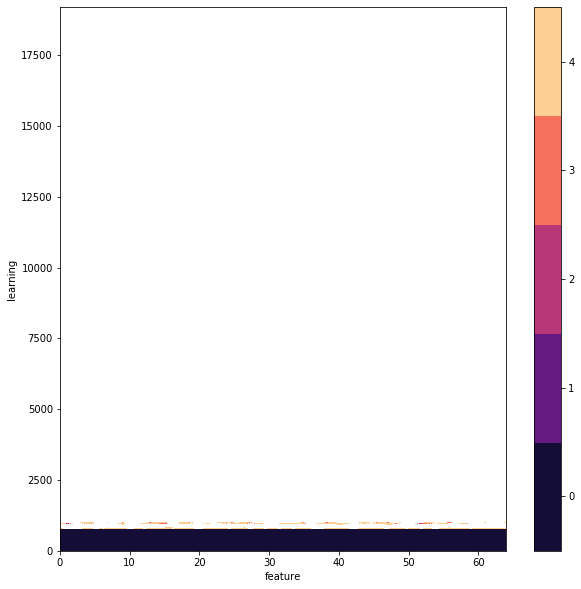

In [73]:
X = np.linspace(0, result.size(1),result.size(1))
Y = np.linspace(0, result.size(0),result.size(0))
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,10))

plt.contourf(X, Y, result.numpy(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")
# ax.plot_surface(X,Y,result.numpy())
print(result.numpy().shape)
print(X.shape)

result[result<4] = 0
result[result==4] = 1
four = torch.sum(result, dim = 1)
print(torch.max(four))

In [74]:

### Column Initialization ###

MyColumn = Column(num_neurons, threshold, 12, 0)
    
cat = DatasetContext2(cat_context1)
trainLoader = DataLoader(cat, batch_size=1000, shuffle=True)

num_epochs = 40
result = torch.zeros(num_epochs*cat.__len__(), num_neurons)
for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)





  0%|          | 0/1 [00:00<?, ?it/s]

IndexError: too many indices for tensor of dimension 4

(240, 64)
(240, 64)
tensor(0.)


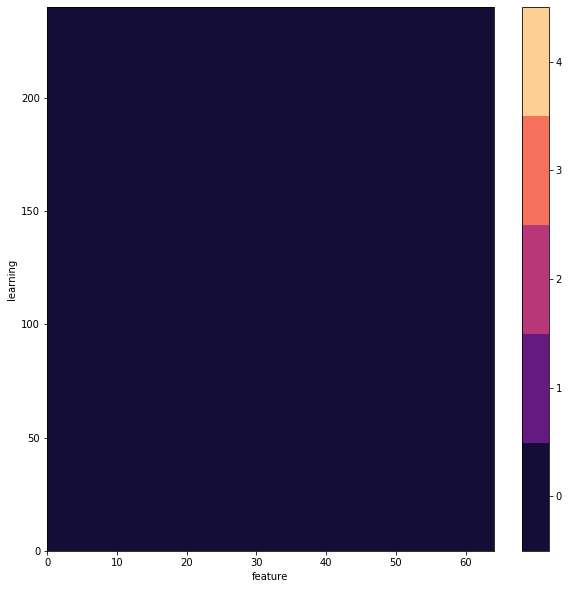

In [75]:
X = np.linspace(0, result.size(1),result.size(1))
Y = np.linspace(0, result.size(0),result.size(0))
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,10))

plt.contourf(X, Y, result.numpy(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")
# ax.plot_surface(X,Y,result.numpy())
print(result.numpy().shape)
print(X.shape)

result[result<4] = 0
result[result==4] = 1
four = torch.sum(result, dim = 1)
print(torch.max(four))

(9600, 16)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


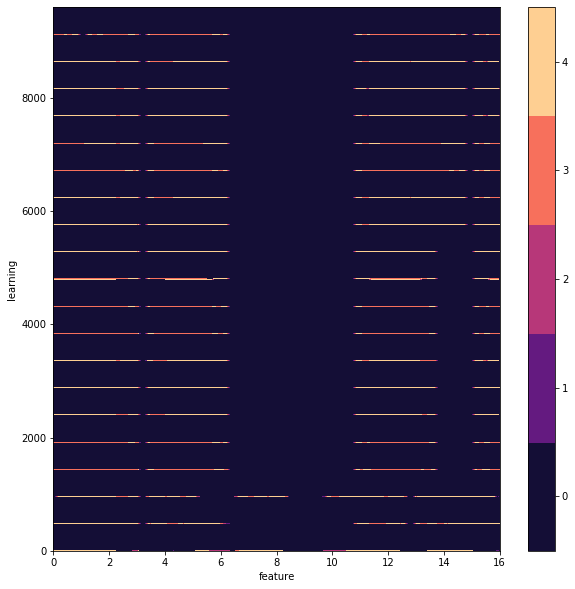

In [76]:
X = np.linspace(0, result2.size(1),result2.size(1))
Y = np.linspace(0, result2.size(0),result2.size(0))
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,10))

plt.contourf(X, Y, result2.numpy(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")
# ax.plot_surface(X,Y,result.numpy())
print(result2.numpy().shape)
print(result2.numpy()[-1,:])


In [77]:
print(result2.numpy()[-2,:])
print(result2.numpy()[-3,:])
print(result2.numpy()[-4,:])

print(result2.numpy()[0,:])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 7. 29. 29.  0.  0. 25.  0. 25.  0.  0. 25. 25.  0. 25. 25.  0.]


In [78]:
temporal_transform = utils.Intensity2Latency(timesteps)

### Column Initialization ###

MyColumn = Column(num_neurons, threshold, 8, 0)
    
cat = DatasetContext(cat_context)
sit = DatasetContext(sit_context)

trainLoader1 = DataLoader(cat, shuffle=True)
trainLoader2 = DataLoader(sit, shuffle = True)

num_epochs = 20
result1 = torch.zeros(num_epochs*(cat.__len__()), num_neurons)
result2 = torch.zeros(num_epochs*(sit.__len__()), num_neurons)
result3 = torch.zeros(num_epochs*(cat.__len__()), num_neurons)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader1):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result1[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader2):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result2[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader1):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result3[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

/s]




 11%|█         | 53/480 [00:00<00:02, 173.56it/s]




 15%|█▍        | 71/480 [00:00<00:02, 175.17it/s]




 19%|█▉        | 90/480 [00:00<00:02, 178.12it/s]




 23%|██▎       | 109/480 [00:00<00:02, 180.75it/s]




 26%|██▋       | 127/480 [00:00<00:01, 179.71it/s]




 30%|███       | 144/480 [00:00<00:01, 174.27it/s]




 34%|███▎      | 161/480 [00:00<00:01, 169.17it/s]




 37%|███▋      | 178/480 [00:01<00:01, 164.78it/s]




 41%|████      | 196/480 [00:01<00:01, 168.06it/s]




 45%|████▍     | 215/480 [00:01<00:01, 173.09it/s]




 49%|████▉     | 234/480 [00:01<00:01, 176.58it/s]




 52%|█████▎    | 252/480 [00:01<00:01, 175.24it/s]




 56%|█████▋    | 270/480 [00:01<00:01, 167.88it/s]




 60%|█████▉    | 287/480 [00:01<00:01, 166.27it/s]




 63%|██████▎   | 304/480 [00:01<00:01, 162.39it/s]




 67%|██████▋   | 323/480 [00:01<00:00, 167.80it/s]




 71%|███████   | 341/480 [00:01<00:00, 169.61it/s]




 75%|███████▌  | 360/480 [00:02<00:00, 173.59it/s]




 79%|

(28800, 64)


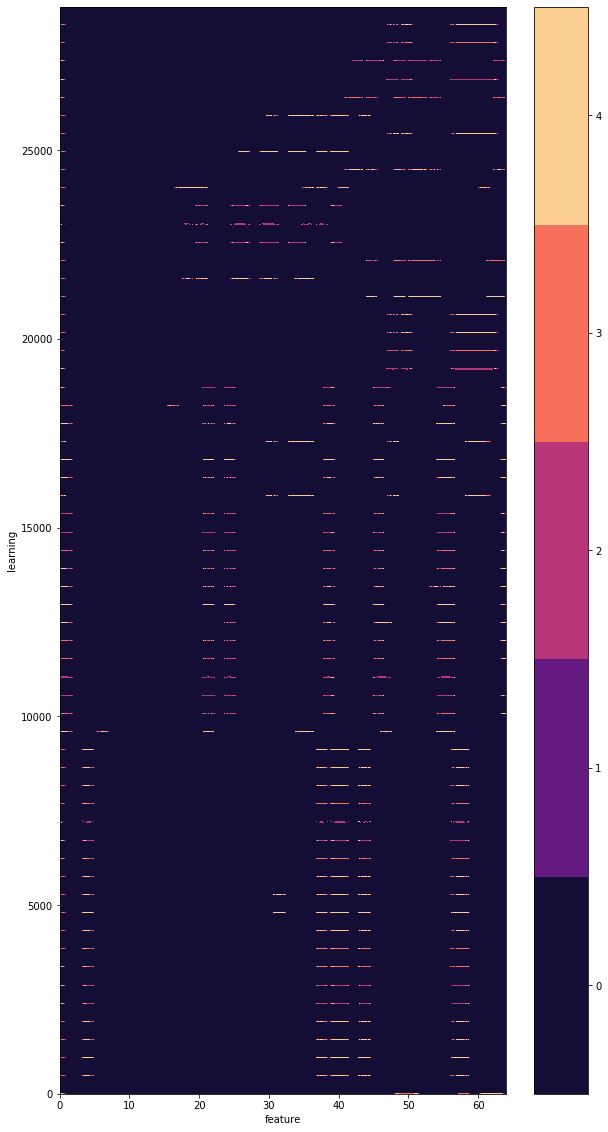

In [79]:
Z = np.concatenate((result1.numpy(), result2.numpy(), result3.numpy()), axis=0)
print(Z.shape)
X = np.linspace(0, Z.shape[1],Z.shape[1])
Y = np.linspace(0, Z.shape[0],Z.shape[0])
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,20))

plt.contourf(X, Y, Z, [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")
plt.savefig("temp_64.jpg")